In [1]:
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import networkx as nx

In [67]:
import community
from pyCombo import combo, modularity

In [61]:
G = nx.dorogovtsev_goltsev_mendes_graph(3)

In [62]:
pos=nx.spring_layout(G)

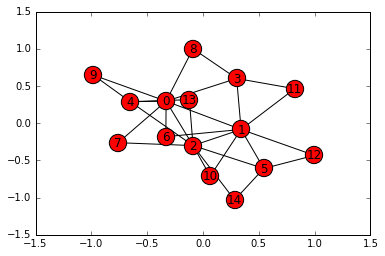

In [63]:
nx.draw_networkx(G,pos)

In [64]:
nx.set_edge_attributes(G, 'weight', [1]*G.number_of_edges())

In [65]:
partition = combo(G, weight='weight')

In [68]:
partition = community.best_partition(G)

TypeError: unsupported operand type(s) for +: 'int' and 'list'

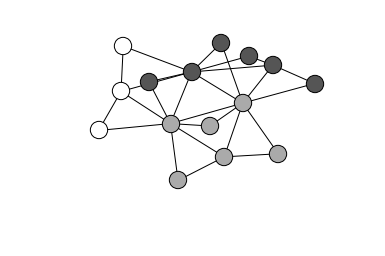

In [57]:
size = float(len(set(partition.values())))

count = 0.
for com in set(partition.values()) :
    count+= 1.
    c = count / size
    
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 300,
                                node_color = str(c))


nx.draw_networkx_edges(G,pos, alpha=1)
plt.axis('off');
plt.show()
